# Question 1

In this question we will
- Implement the vector grandient operators for colour images.
- Implement the kurtosis measure of image blur/sharpness which is caluclated from image gradients and assess whether it is a reasonable metric of blur.
- Learn to create blur maps of images to visualize the amount of blur in local image patches.



# Step 1: Implement the vector gradient.

Implement the vector gradient as described in the lecture slides in the `color_sobel_edges()` function below.  Use Sobel filters to estimate partial derivatives.  Use the `color_dot_product()` function (provided) to compute the necessary dot products to obtain gxx, gyy, and gxy.  Return an array containing the gradient magnitudes for each pixel, i.e. a graident magnitude image.  Optionally, return a second array containing the gradient directions for each pixel.

The input image must be dtype `float` or `uint8`.  If it is `uint8` convert it to `float` before processing.  Leave the magnitude image ouput as dtype `float` regardless of the input's dtype.

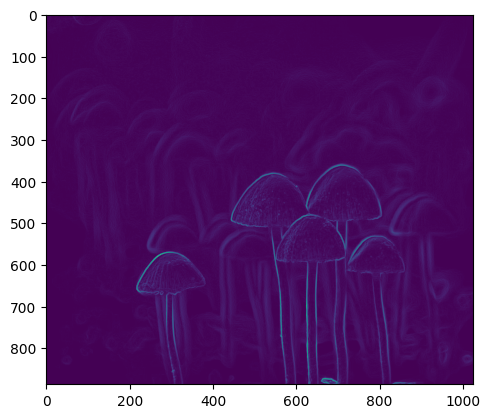

In [40]:
import skimage.util as util
import numpy as np
import skimage.filters as filt
import skimage.io as skio

def color_dot_product(A, B):
    '''
    Element-by-element dot product in a 2D array of vectors.

    :return: An array in which index [i,j] is the dot product of A[i,j,:] and B[i,j,:].
    '''
    return np.sum(A.conj()*B, axis=2)



def color_sobel_edges(I):
    '''
    Finish me!
    
    :param I: Input image (dtype float or uint8)
    :return: Gradient direction and magnitude images
    '''
    
    if I.dtype == np.uint8:
        I = util.img_as_float(I)
        
    R_x = filt.sobel_v(I[:, :, 0]) 
    R_y = filt.sobel_h(I[:, :, 0])  

    G_x = filt.sobel_v(I[:, :, 1])  
    G_y = filt.sobel_h(I[:, :, 1])  

    B_x = filt.sobel_v(I[:, :, 2]) 
    B_y = filt.sobel_h(I[:, :, 2])
    
    
    U = np.stack([R_x, G_x, B_x], axis=-1)
    V = np.stack([R_y, G_y, B_y], axis=-1)
    
    # print(U)
    
    g_xx = color_dot_product(U, U)
    g_yy = color_dot_product(V, V)
    g_xy = color_dot_product(U, V)
    
    gradient_direction = 0.5 * np.arctan2(2 * g_xy, g_xx - g_yy)
    gradient_magnitude = np.sqrt(
        0.5 * 
        (
            (g_xx + g_yy) + (g_xx - g_yy) * np.cos(2 * gradient_direction) + 2 * g_xy * np.sin(2 * gradient_direction)
              
        )
    )
    
    
    return (gradient_direction, gradient_magnitude)

# print(color_sobel_edges(skio.imread("mushroom.jpg"))[1])
# color_sobel_edges(skio.imread("mushroom.jpg"))
mushroom_grad_m = color_sobel_edges(skio.imread("mushroom.jpg"))[1]
plt.figure()
plt.imshow(mushroom_grad_m)

# mushroom_grad_m_flat = mushroom_grad_m.flatten()
# plt.figure(figsize=(8, 6))
# plt.hist(mushroom_grad_m_flat, bins=50, color='blue', edgecolor='black')
# plt.title('Histogram of Gradient Magnitudes')
# plt.xlabel('Gradient Magnitude')
# plt.ylabel('Frequency')
# plt.show()

# Step 2: Examine behavior of the kurtosis sharpness metric.

Write a function which:

* takes as input an input image, a minimum value of sigma, and a maximum value of sigma.
* applies different amounts of Gaussian blur to the original image for integer values of sigma between the provided minimum and maximum values of sigma. (reminder: sigma describes the standard deviation of the gaussian filter mask used to blur the image).
    * Note: if using `skimage.filters.gaussian()`, you'll need to set the `channel_axis` parameter appropriately since you are applying it to a colour image.
* For each blurred image, compute the gradient magnitude using color_sobel_edges(), then compute compute the kurtosis sharpness measure.  This is *log(k+3)* where *k* is the kurtosis of the gradient magnitude image of the blurred image as described in the assignment description document.  See `scipy.stats.kurtosis()`.
* Return a tuple consisting of the range object of sigma values used and the list of computed kurtosis values for each sigma.

Then:
* Call the function using `mushroom.jpg` as the input image, a minimum sigma of 1, and a maximum sigma of 30.  Use a smaller max sigma until you are sure it's working, then increase to 30, as it can take a few minutes to do all the filtering.  Use the return values from your function to plot a line graph of gaussian blur sigma vs. blur measure (kurtosis) for the waterfall image.  Add appropriate axis labels and a descriptive title.  Sample output is provided in the assignment description document.



Text(0, 0.5, 'Sharpness (Kurtosis)')

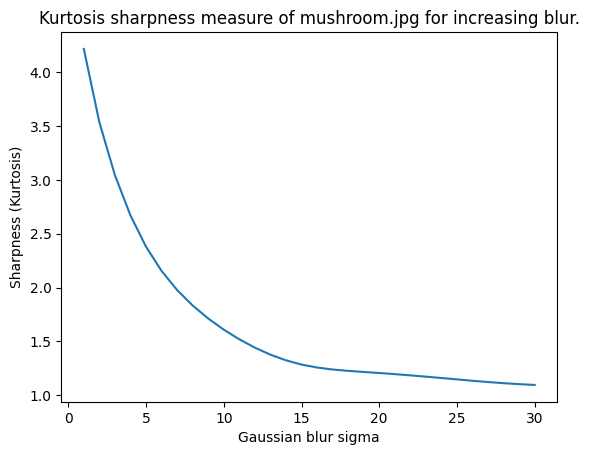

In [19]:

%matplotlib inline
import scipy.stats as st
import math as math
import matplotlib.pyplot as plt

def test_blur_measure(I, min_sigma, max_sigma):
    '''
    Finish me!
    
    :param I: Input image (dtype float or uint8)
    :param min_sigma: minimum value of sigma to applied while blurring
    :param max_sigma: maximum value of sigma to applied while blurring
    :return: list of range of sigma values and list of corresponding kurtosis measure values
    '''
    if I.dtype == np.uint8:
        I = util.img_as_float(I)
        
    kurt_measure = []
    
    for blur in range(min_sigma, max_sigma + 1):
        
        grad_magnitude = color_sobel_edges(filt.gaussian(I, sigma = blur, channel_axis = 2))[1].reshape(-1)
        
        k = st.kurtosis(grad_magnitude)
        
        sharpness = math.log(k+3)
        
        kurt_measure.append(sharpness)
        
    return list(range(min_sigma, max_sigma + 1)), kurt_measure

x, y = test_blur_measure(skio.imread("mushroom.jpg"),1,30)

plt.figure()

plt.plot(x,y)

plt.title("Kurtosis sharpness measure of mushroom.jpg for increasing blur.")
plt.xlabel("Gaussian blur sigma")
plt.ylabel("Sharpness (Kurtosis)")

# Step 3:  Create a local blur map

Write a function which:

* takes as input an image and a window size (in pixels).
* computes the local sharpness of the input image (i.e. log(kurtosis+3)) for each tiled, non-overlapping square window of the given window size
* stores each local sharpness in an array where each entry represents one window of the input image (the size of this array can be computed by integer division of the original image dimensions by the window size)
* returns the array of local sharpnesses.

Then:

- call the function you just wrote with `mushroom.jpg` as the input image and 100 as the window size.  
- Plot the returned array as an image using `plt.imshow()`.  Do not rescale this image with `vmin=` or `vmax=`, and use the default colormap (don't change it to `'gray'`).  
- Add a color scale bar using `plt.colorbar()`.  Sample output is provided in the assignment description document.



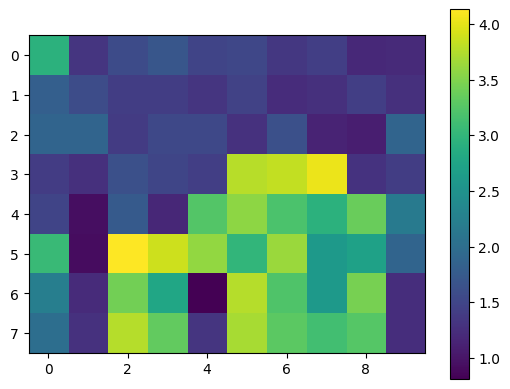

In [31]:
def sharpness_map(I, window_size):
    '''
    
    Finish me!
    
    :param I: Input image (dtype float or uint8)
    :param window_size: size of each tile of whose sharpness is to be measured
    :return: array of local sharpness (sharpness map)
    '''
    if I.dtype == np.uint8:
        I = util.img_as_float(I)
        
    r, c, chan  = I.shape
    
    rows = r // window_size
    cols = c // window_size

    sharpness_map = np.empty((rows, cols))

    for i in range(rows):
        for j in range(cols):
            
            start_row, start_col = i * window_size, j * window_size
            
            window = I[start_row:start_row + window_size, start_col:start_col + window_size, :]

            grad_magnitude = color_sobel_edges(window)[1].reshape(-1)

            k = st.kurtosis(grad_magnitude)
            
            sharpness = math.log(k + 3)

            sharpness_map[i, j] = sharpness

    return sharpness_map


plt.figure()
mushroom_map = sharpness_map(skio.imread("mushroom.jpg"), 100)
bar = plt.imshow(mushroom_map)
plt.colorbar(bar)


# Step 4: Try it on another image.

Use the functions you wrote to produce the same plots as in steps 2 and 3 but for the `waterfall.jpg` image instead.


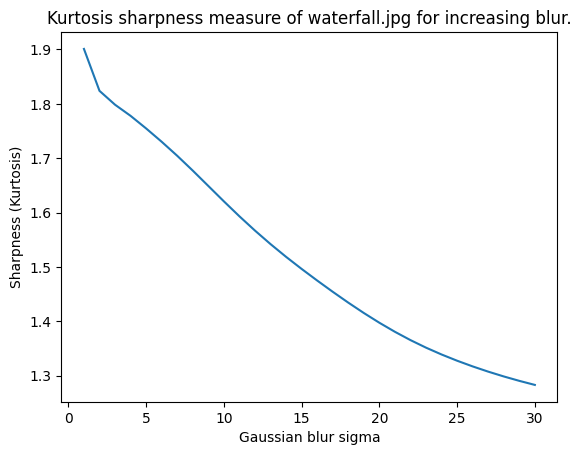

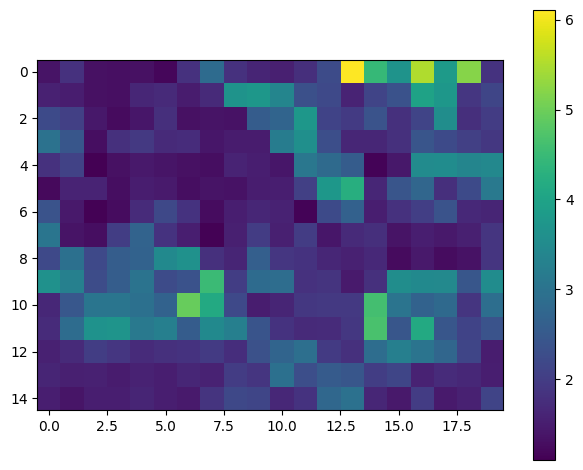

In [33]:
# Write your code here.

s,t = test_blur_measure(skio.imread("waterfall.jpg"),1,30)

plt.figure()
plt.plot(s,t)
plt.title("Kurtosis sharpness measure of waterfall.jpg for increasing blur.")
plt.xlabel("Gaussian blur sigma")
plt.ylabel("Sharpness (Kurtosis)")

plt.figure()
waterfall_map = sharpness_map(skio.imread("waterfall.jpg"), 100)
bar_w = plt.imshow(waterfall_map)
plt.colorbar(bar_w)

plt.tight_layout()

# Step 5: Thinking and Qualitative Analysis

### Answer the following questions, right here in this block.

1. Based on your observations of the previous results (you can try it on additional images if you wish), discuss the advantages and disadvantages of the kurtosis-based measure of image sharpness, citing specific evidence observed to justify your claims.

	_Your answer:_  
   *ADV
    The kurtosis-based measure is sensitive to high-magnitude gradients, which typically occur at sharp edges. Since kurtosis measures the “tailedness” of the distribution, sharp images with many pronounced edges will have a larger spread of gradient magnitudes, leading to higher kurtosis values. For eg the sharpness map gives a better idea of where the image is sharper and where its more blurred. By taking the logarithm of the kurtosis, we reduce the effect of extreme outliers and produce a smoother measure that is easier to interpret in varying levels of sharpness and blur.
    *DIS
    The kurtosis-based sharpness metric does not work well for images that contain subtle textures or fine details with low gradients. For such images, the gradient magnitudes are small, and kurtosis may not differentiate them well from blurry images. As observed in the kurtosis curve for increasing blur (particularly for images like mushroom.jpg and waterfall.jpg), the kurtosis measure can fluctuate in the low blur range. This suggests that it might not behave as smoothly as expected for small levels of blur, possibly making it less reliable in detecting subtle blur variations. The sharpness map for waterfall image does not give a good idea of where the image is sharper since their is lesser depth available.

    
2. Think of what the shape of a histogram of gradient magnitudes would look like for a sharp image.  Why does this set of gradient magnitudes have high kurtosis?  (It might help to look up kurtosis and see what it measures about a histogram!)

	_Your answer:_  
    
    For a sharp image, the histogram of gradient magnitudes would have a tall, narrow peak near zero and heavy tails extending far from the center, where higher gradient magnitudes are represented. Kurtosis measures the tailedness of a distribution. A distribution with high kurtosis has more of its variance due to infrequent extreme deviations (outliers), in this case, high gradient values at the sharp edges.


3. Now think what would happen as that same image gets blurrier.  Explain how the shape of the histogram would change, and the corresponding effect on the kurtosis.

	_Your answer:_  
    
    As the image becomes blurrier, the sharp edges are smoothed out, leading to a decrease in high gradient magnitudes. This causes the peak of the histogram (which is around the low gradient values) to flatten because the number of pixels with low gradients increases. As the image gets blurrier, the tails of the histogram become shorter, meaning there are fewer extreme gradient values (less variation). The peak flattens because more of the pixels have low gradients. As the tails shrink and the peak flattens, the kurtosis decreases. 